# Reading Matfile

In [1]:
from scipy.io import loadmat
import numpy as np
matfile_images = loadmat('stack.mat')
n_frames = int(matfile_images['numframes'])
print(n_frames)

100


# Storing stack of images in a dictionary

In [2]:
frames = {}
# storing images in a dictionary
for key in matfile_images.keys():
    if key[:5] == 'frame':
        frames[int(key[5:])] = matfile_images[key]

In [3]:
np.shape(frames[1])

(115, 115)

In [4]:
print(frames[1])

[[56 56 57 ... 52 51 51]
 [56 56 57 ... 52 51 51]
 [57 57 58 ... 53 52 52]
 ...
 [52 52 53 ... 58 57 57]
 [51 51 52 ... 58 57 57]
 [51 51 52 ... 57 57 56]]


# Defining $\Delta d$ and partial double derivatives 
$\Delta d=50.50$,
Partial double derivatives as a kernel can be represented as 
\begin{equation}
\frac{\partial^2 f}{\partial x^2} = \begin{bmatrix}
0 & 0 & 0\\
1 & -2 & 1\\
0 & 0 & 0
\end{bmatrix} 
\end{equation}


\begin{equation}
\frac{\partial^2 f}{\partial y^2} = \begin{bmatrix}
0 & 1 & 0\\
1 & -2 & 1\\
0 & 1 & 0
\end{bmatrix} 
\end{equation}

In [5]:

delta_d=50.50
lx = np.array([[0,  0, 0], 
               [1, -2, 1], 
               [0,  0, 0]])
ly = np.array([[0,  1, 0], 
               [0, -2, 0], 
               [0,  1, 0]])

# Covolution

In [6]:
def convolution(image,kernel):
    [x,y]=np.shape(image);
    k=len(kernel);
    filtered_image = np.zeros((x, y))
    d = k//2
    if d==0:
        return image
    zero_padded_image = np.zeros((x+2*d, y+2*d))
    zero_padded_image[d:-d, d:-d] = image #fit the image to the center of the zero padded image
    for i in range(d, x+d):
        for j in range(d, y+d):
            patch = zero_padded_image[i-d:i+d+1, j-d:j+d+1] #patch of the input image on which kernel needs to be applied for this iteration
            filtered_image[i-d, j-d] = np.sum(kernel*patch) #apply kernel and sum these values 
    return filtered_image

# Shape from focus

To get shape from focus i.e obtaining focus points at each pixel from stack of images we use sum modified laplacian as a focus measure operator. The sum modified laplacian(SML) can be calculated using modified laplacian(ML) as follows:

For a given input image I its ML will be $ML=|I_{xx}|+|I_{yy}|$ where $I_{xx} and I_{yy}$ are the convolution of image I with  double partial derivatives given as 

\begin{equation}
I_{xx} = I*\frac{\partial^2 f}{\partial x^2}
\end{equation}


\begin{equation}
I_{yy}= I*\frac{\partial^2 f}{\partial y^2}  
\end{equation}

Now the sum modified laplacian is calculated as 
$$SML=\sum^q_{i=-q}\sum^q_{j=-q}\,ML(x+i,y+j)$$

Once SML has been calculated for each pixel location the frame where in which maximum focus is obtained is choosen and the corresponding pixel value at that location is in focus.

In [8]:
def SFF(q):
    [x,y]=np.shape(frames[1])
    stacked=np.zeros((x,y,n_frames))
    for i in range(n_frames):
        img=frames[i+1]
        k=2*q+1
        kernel=np.ones((k,k))
        I_xx=convolution(img,lx)
        I_yy=convolution(img,ly)
        ML=np.abs(I_xx)+np.abs(I_yy)
        SML=convolution(ML,kernel)
        stacked[:,:,i]=SML
    max_focus_frames = {} 
    max_focus_frames=np.argmax(stacked,axis=2)
    depth=max_focus_frames*delta_d
    focused_images = np.zeros((x, y))
    for i in range(x):
        for j in range(y):
            frame=max_focus_frames[i,j]+1
            focused_images[i,j]=frames[frame][i,j]
    return focused_images,depth

# Plotting 

Text(0.5, 1.0, '$q$ = 2')

<Figure size 432x288 with 0 Axes>

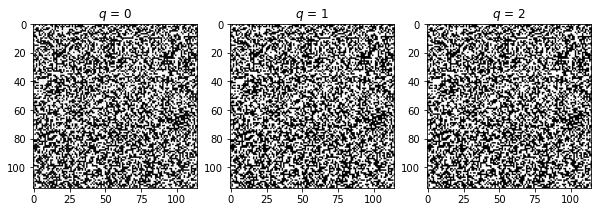

In [9]:
import matplotlib.pyplot as plt

plt.figure()
plt.subplots(1,3,figsize=(10,10))

focused_images_q0,depth_q0=SFF(0)
plt.subplot(1,3,1)
plt.imshow(focused_images_q0,'gray')
plt.title(f"$q$ = 0")

focused_images_q1,depth_q1=SFF(1)
plt.subplot(1,3,2)
plt.imshow(focused_images_q1,'gray')
plt.title(f"$q$ = 1")

focused_images_q2,depth_q2=SFF(2)
plt.subplot(1,3,3)
plt.imshow(focused_images_q2,'gray')
plt.title(f"$q$ = 2")

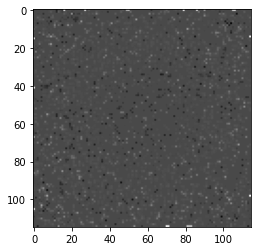

In [10]:
plt.imshow(focused_images_q0-focused_images_q2,'gray') #checking if there is any minute differences between the focused images 

In [11]:
depths=np.array([depth_q0,depth_q1,depth_q2])

# Plotting Depth Maps

In [12]:
from matplotlib import cm
def depth_plot(q, size=(10, 10),colormap=cm.jet):
    fig = plt.figure(figsize=size)
    ax = plt.axes(projection='3d')
    x, y = np.shape(frames[1])
    X, Y = np.meshgrid(np.arange(x)+1, np.arange(y)+1)
    surf = ax.plot_surface(
        X, Y, depths[q],cmap=colormap, linewidth=0, antialiased=False)
    title = rf"Depth Map for $q$ = {q}"
    plt.title(title)
    fig.colorbar(surf)
    plt.show()

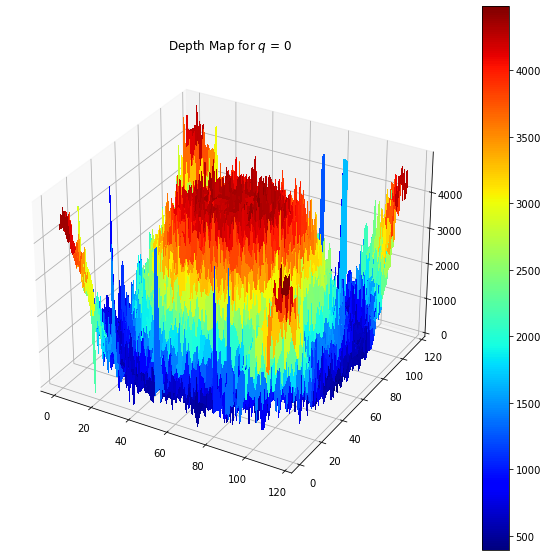

In [13]:
depth_plot(0)

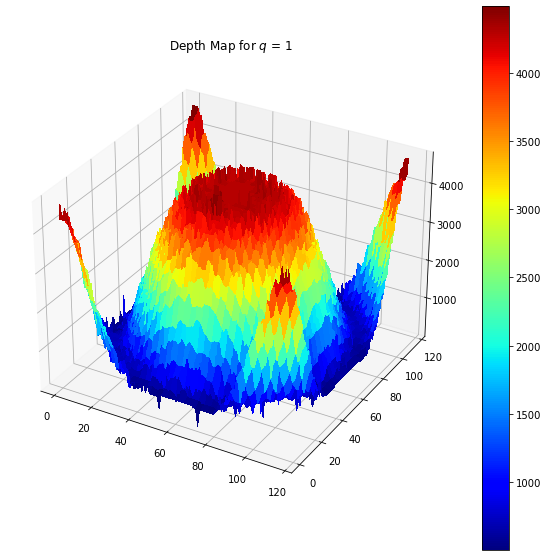

In [14]:
depth_plot(1)

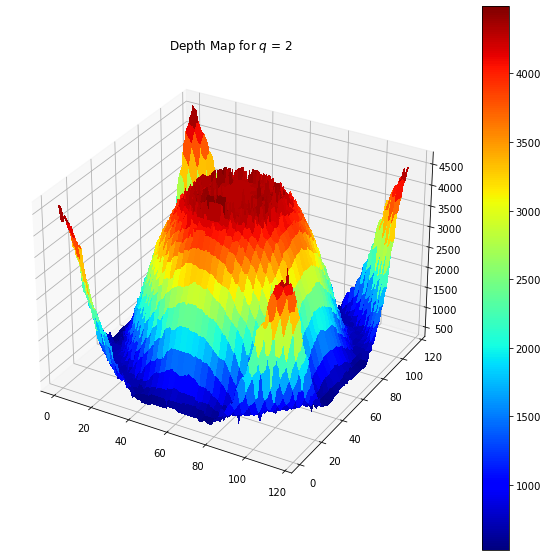

In [15]:
depth_plot(2)